In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost
from xgboost import XGBClassifier

# Import files

In [2]:
# --- overlay sample
file1 = '../rootfiles/checkout_prodgenie_numi_overlay_run1.root'
file2 = '../rootfiles/checkout_overlay_numi_run1_particle_flow.root' # new sample generated using the unified workflow
file3 = '../rootfiles/checkout_prodgenie_numi_overlay_run1_OFFSETFIXED2.root'


# --- intrinsic nue sample
#file1 = '../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root'
#file2 = '../rootfiles/checkout_intrinsic_nue_numi_run1_particle_flow.root' # new sample generated using the unified workflow
#file3 = '../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1_OFFSETFIXED2.root'

# Calculate number of entries and POT

In [3]:
kine_vars   = ['kine_reco_Enu','kine_pio_vtx_dis','kine_pio_energy_1']
bdt_vars    = ['numu_cc_flag','nue_score']
pot_vars    = ['runNo','subRunNo','pot_tor875','pot_tor875good','spill_tor875','spill_tor875good']
pfeval_vars = ['truth_corr_nuvtxX','truth_corr_nuvtxY','truth_corr_nuvtxZ','reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ']
eval_vars   = ['truth_isCC','truth_nuPdg','truth_vtxInside','weight_spline', 'weight_cv',
               'match_found', 'stm_eventtype', 'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead','stm_clusterlength',
               'truth_energyInside', 'match_completeness_energy',
               'run','subrun','event']

# --- variables calculated by me
extra_vars  = ['cos_theta'] 


def create_dataframe(file, family):

    # --- import trees and variables
    T_pot = uproot.open(file)['wcpselection/T_pot']
    df_pot = T_pot.pandas.df(pot_vars, flatten=False)
    print('T_pot     %i entries' % len(df_pot))
    
    T_KINE = uproot.open(file)['wcpselection/T_KINEvars']
    df_KINE = T_KINE.pandas.df(kine_vars, flatten=False)
    print('T_kine    %i entries' % len(df_KINE))

    T_BDT = uproot.open(file)['wcpselection/T_BDTvars']
    df_BDT = T_BDT.pandas.df(bdt_vars, flatten=False)
    print('T_BDT     %i entries' % len(df_BDT))
            
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    df_PFeval = T_PFeval.pandas.df(pfeval_vars, flatten=False)
    print('T_PFeval  %i entries' % len(df_PFeval))

    T_eval = uproot.open(file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(eval_vars, flatten=False)
    print('T_eval    %i entries' % len(df_eval))

    # --- merge dataframes
    df = pd.concat([df_KINE, df_PFeval, df_BDT, df_eval, df_pot], axis=1)

    # --- calculate POT
    POT = sum(df_pot.pot_tor875)

    return df, POT

print('%s' % file1)
df_file1, POT1 = create_dataframe(file1,'MC')
print('POT       %.2e' % POT1)
print('Entries   %i\n' % len(df_file1))

print('%s' % file2)
df_file2, POT2 = create_dataframe(file2,'MC')
print('POT       %.2e' % POT2)
print('Entries   %i\n' % len(df_file2))

print('%s' % file3)
df_file3, POT3 = create_dataframe(file3,'MC')
print('POT       %.2e' % POT3)
print('Entries   %i\n' % len(df_file3))

../rootfiles/checkout_prodgenie_numi_overlay_run1.root
T_pot     24372 entries
T_kine    107221 entries
T_BDT     107221 entries
T_PFeval  107221 entries
T_eval    107221 entries
POT       2.72e+20
Entries   107221

../rootfiles/checkout_overlay_numi_run1_particle_flow.root
T_pot     24372 entries
T_kine    107221 entries
T_BDT     107221 entries
T_PFeval  107221 entries
T_eval    107221 entries
POT       3.90e+07
Entries   107221

../rootfiles/checkout_prodgenie_numi_overlay_run1_OFFSETFIXED2.root
T_pot     24359 entries
T_kine    107150 entries
T_BDT     107150 entries
T_PFeval  107150 entries
T_eval    107150 entries
POT       2.71e+20
Entries   107150



In [16]:
df_file1.head()

,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,numu_cc_flag,...,match_completeness_energy,run,subrun,event,runNo,subRunNo,pot_tor875,pot_tor875good,spill_tor875,spill_tor875good
entry,,,,,,,,,,,,,,,,,,,,,
0,-1.0,-1.0,-1.0,14.896067,73.916512,296.026154,-1.0,-1.0,-1.0,-1.0,...,2867.492188,5233,99,4963,5233.0,99.0,4.012238e+15,4.012238e+15,0.0,0.0
1,-1.0,-1.0,-1.0,214.317368,-150.303711,49.464687,-1.0,-1.0,-1.0,-1.0,...,0.000000,5233,99,4980,5066.0,14.0,3.563513e+15,3.563513e+15,0.0,0.0
2,-1.0,-1.0,-1.0,-5.454307,119.502953,780.231689,-1.0,-1.0,-1.0,-1.0,...,0.000000,5066,14,706,5598.0,47.0,7.413017e+15,7.413017e+15,0.0,0.0
3,-1.0,-1.0,-1.0,181.752441,-4.253470,835.219055,-1.0,-1.0,-1.0,-1.0,...,405.120483,5066,14,723,5598.0,48.0,1.617758e+16,1.617758e+16,0.0,0.0
4,-1.0,-1.0,-1.0,-21.181168,-2.389918,335.854401,-1.0,-1.0,-1.0,-1.0,...,286.380646,5066,14,731,5598.0,49.0,1.186537e+16,1.186537e+16,0.0,0.0


In [4]:
def merge_left_only(df_left, df_right):
    df = pd.merge(df_left, df_right, on=['run','subrun','event'],suffixes=('', '_delme'), how='left', indicator=True).query("_merge == 'left_only'")
    df_new = df[[c for c in df.columns if not c.endswith('_delme')]]
    return df_new

df_file1_new = merge_left_only(df_file1,df_file1)
print('Remaining events: %i' % len(df_file1_new))

Remaining events: 0


# Plot difference between file2-file1

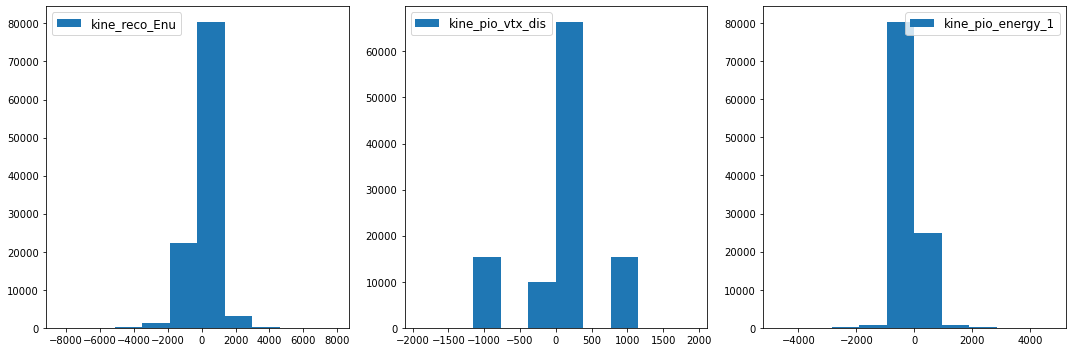

In [5]:
legend_size = 12

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2.kine_reco_Enu-df_file1.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2.kine_pio_vtx_dis-df_file1.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2.kine_pio_energy_1-df_file1.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

# Plot the difference between file2-file3

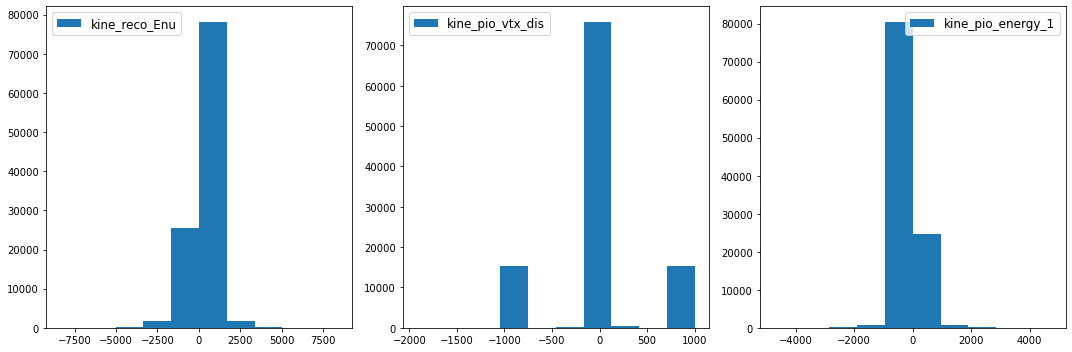

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2.kine_reco_Enu-df_file3.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2.kine_pio_vtx_dis-df_file3.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2.kine_pio_energy_1-df_file3.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

In [7]:
columns = ['run','subrun','event','runNo','subRunNo']

df_file1.loc[0:10,columns]

,run,subrun,event,runNo,subRunNo
entry,,,,,
0,5233,99,4963,5233.0,99.0
1,5233,99,4980,5066.0,14.0
2,5066,14,706,5598.0,47.0
3,5066,14,723,5598.0,48.0
4,5066,14,731,5598.0,49.0
5,5598,47,2352,5598.0,50.0
6,5598,47,2361,5598.0,51.0
7,5598,47,2386,5598.0,52.0
8,5598,47,2388,5598.0,87.0


In [8]:
df_file2.loc[0:10,columns]

,run,subrun,event,runNo,subRunNo
entry,,,,,
0,5233,99,4963,5233.0,99.0
1,5233,99,4980,5470.0,61.0
2,5470,61,3056,5470.0,62.0
3,5470,61,3066,5470.0,63.0
4,5470,61,3073,5059.0,11.0
5,5470,61,3079,5509.0,60.0
6,5470,61,3083,5509.0,61.0
7,5470,61,3087,5509.0,62.0
8,5470,61,3089,5051.0,123.0


In [9]:
df_file3.loc[0:10,columns]

,run,subrun,event,runNo,subRunNo
entry,,,,,
0,5233,99,4963,5233.0,99.0
1,5233,99,4980,5066.0,14.0
2,5066,14,706,5598.0,47.0
3,5066,14,723,5598.0,48.0
4,5066,14,731,5598.0,49.0
5,5598,47,2352,5598.0,50.0
6,5598,47,2361,5598.0,51.0
7,5598,47,2386,5598.0,52.0
8,5598,47,2388,5598.0,87.0


In [10]:
# create new dataframes that contain the same run and subrun numbers

df_file1_subsample = df_file1[(df_file1.subrun==99)]
df_file1_subsample.head()

,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,numu_cc_flag,...,match_completeness_energy,run,subrun,event,runNo,subRunNo,pot_tor875,pot_tor875good,spill_tor875,spill_tor875good
entry,,,,,,,,,,,,,,,,,,,,,
0,-1.0,-1.0,-1.0,14.896067,73.916512,296.026154,-1.0,-1.0,-1.0,-1.0,...,2867.492188,5233,99,4963,5233.0,99.0,4.012238e+15,4.012238e+15,0.0,0.0
1,-1.0,-1.0,-1.0,214.317368,-150.303711,49.464687,-1.0,-1.0,-1.0,-1.0,...,0.000000,5233,99,4980,5066.0,14.0,3.563513e+15,3.563513e+15,0.0,0.0
626,-1.0,-1.0,-1.0,185.117767,-47.292133,1111.857788,-1.0,-1.0,-1.0,-1.0,...,0.000000,5564,99,4957,5914.0,91.0,1.485569e+16,1.485569e+16,0.0,0.0
627,-1.0,-1.0,-1.0,279.059113,20.679972,827.132874,-1.0,-1.0,-1.0,-1.0,...,0.000000,5564,99,4976,5914.0,92.0,3.678193e+15,3.678193e+15,0.0,0.0
628,-1.0,-1.0,-1.0,144.747192,96.975822,571.838501,-1.0,-1.0,-1.0,-1.0,...,232.332611,5564,99,4993,5914.0,93.0,9.250496e+15,9.250496e+15,0.0,0.0


In [11]:
df_file2_subsample = df_file2[(df_file2.subrun==99)]
df_file2_subsample.head()

,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,numu_cc_flag,...,match_completeness_energy,run,subrun,event,runNo,subRunNo,pot_tor875,pot_tor875good,spill_tor875,spill_tor875good
entry,,,,,,,,,,,,,,,,,,,,,
0,-1.0,-1.0,-1.0,14.896067,73.916512,296.026154,-1.0,-1.0,-1.0,-1.0,...,2867.492188,5233,99,4963,5233.0,99.0,2648.505859,2648.505859,570.0,570.0
1,-1.0,-1.0,-1.0,214.317368,-150.303711,49.464687,-1.0,-1.0,-1.0,-1.0,...,0.000000,5233,99,4980,5470.0,61.0,0.000000,0.000000,0.0,0.0
534,-1.0,-1.0,-1.0,185.117767,-47.292133,1111.857788,-1.0,-1.0,-1.0,-1.0,...,0.000000,5564,99,4957,5437.0,116.0,1988.815796,1988.815796,438.0,438.0
535,-1.0,-1.0,-1.0,279.059113,20.679972,827.132874,-1.0,-1.0,-1.0,-1.0,...,0.000000,5564,99,4976,5437.0,117.0,1743.364624,1743.364624,384.0,384.0
536,-1.0,-1.0,-1.0,144.747192,96.975822,571.838501,-1.0,-1.0,-1.0,-1.0,...,232.332611,5564,99,4993,5437.0,118.0,1838.562744,1838.562744,405.0,405.0


In [12]:
df_file3_subsample = df_file3[(df_file3.subrun==99)]
df_file3_subsample.head()

,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,numu_cc_flag,...,match_completeness_energy,run,subrun,event,runNo,subRunNo,pot_tor875,pot_tor875good,spill_tor875,spill_tor875good
entry,,,,,,,,,,,,,,,,,,,,,
0,-1.0,-1.0,-1.0,14.896067,73.916512,296.026154,-1.0,-1.0,-1.0,-1.0,...,2867.492188,5233,99,4963,5233.0,99.0,4.012238e+15,4.012238e+15,0.0,0.0
1,-1.0,-1.0,-1.0,214.317368,-150.303711,49.464687,-1.0,-1.0,-1.0,-1.0,...,0.000000,5233,99,4980,5066.0,14.0,3.563513e+15,3.563513e+15,0.0,0.0
626,-1.0,-1.0,-1.0,185.117767,-47.292133,1111.857788,-1.0,-1.0,-1.0,-1.0,...,0.000000,5564,99,4957,5914.0,91.0,1.485569e+16,1.485569e+16,0.0,0.0
627,-1.0,-1.0,-1.0,279.059113,20.679972,827.132874,-1.0,-1.0,-1.0,-1.0,...,0.000000,5564,99,4976,5914.0,92.0,3.678193e+15,3.678193e+15,0.0,0.0
628,-1.0,-1.0,-1.0,144.747192,96.975822,571.838501,-1.0,-1.0,-1.0,-1.0,...,232.332611,5564,99,4993,5914.0,93.0,9.250496e+15,9.250496e+15,0.0,0.0


# Plotting the same run/subrun/event

In [13]:
# plotting the variable difference for events with the same run/subrun/event

df_new = df_file1[(df_file1.run==df_file2.run) & (df_file1.subrun==df_file2.subrun) & (df_file2.event==df_file2.event)]
columns = ['run','subrun','event','runNo','subRunNo']

df_new.loc[:,columns]

,run,subrun,event,runNo,subRunNo
entry,,,,,
0,5233,99,4963,5233.0,99.0
1,5233,99,4980,5066.0,14.0
41716,4962,141,7094,NaN,NaN
41725,4962,144,7235,NaN,NaN
41726,4962,144,7241,NaN,NaN
41735,4962,148,7419,NaN,NaN
41736,4962,148,7423,NaN,NaN
41737,4962,148,7428,NaN,NaN
41738,4962,148,7441,NaN,NaN


In [14]:
nentries1 = len(df_file1)
nentries2 = len(df_file2)
nentries3 = len(df_file3)

# plot the difference between file1 and file2
h_diff = []
for x in range(nentries1):
    for y in range(nentries2):
        if((df_file1.loc[x,'run']==df_file2.loc[y,'run']) &
           (df_file1.loc[x,'subrun']==df_file2.loc[y,'subrun']) &
           (df_file1.loc[x,'event']==df_file2.loc[y,'event'])):
                h_diff.append(df_file1.loc[x,'kine_reco_Enu']-df_file2.loc[y,'kine_reco_Enu'])

KeyboardInterrupt: 

In [ ]:
plt.hist(h_diff)

print(h_diff)

In [ ]:
condition = ((df_file1['run']==df_file2['run']) & (df_file1['subrun']==df_file2['subrun']) & (df_file1['event']==df_file2['event']))

df_file1_new = df_file1[condition]
df_file2_new = df_file2[condition]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2_new.kine_reco_Enu-df_file1_new.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2_new.kine_pio_vtx_dis-df_file1_new.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2_new.kine_pio_energy_1-df_file1_new.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

In [ ]:
df_file2_new = df_file2[condition_run & condition_subrun & condition_event]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2_new.kine_reco_Enu-df_file1_new.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2_new.kine_pio_vtx_dis-df_file1_new.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2_new.kine_pio_energy_1-df_file1_new.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

In [ ]:
# compare the number of entries that exist in both files
print('File1   %i entries' % len(df_file1))
print('File2   %i entries' % len(df_file2))
print('Overlapping entries   %i' % len(df_file1_new))

File3  107150 entries
File2  107221 entries
Remaining events for file3: 107150
Remaining events for file2: 107150


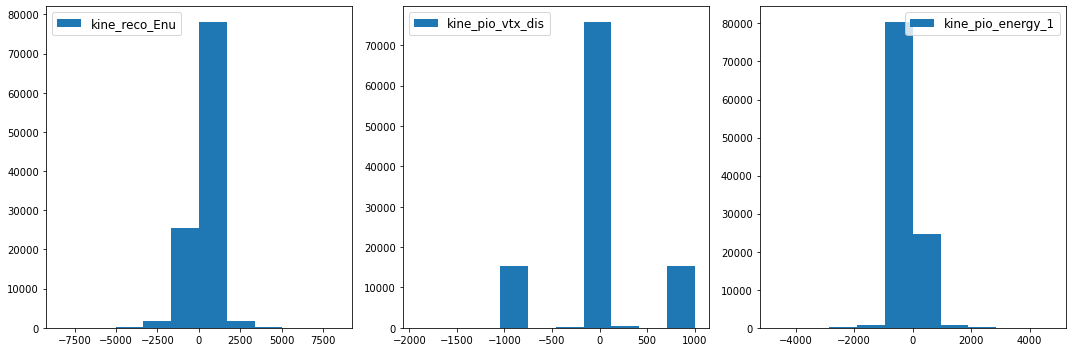

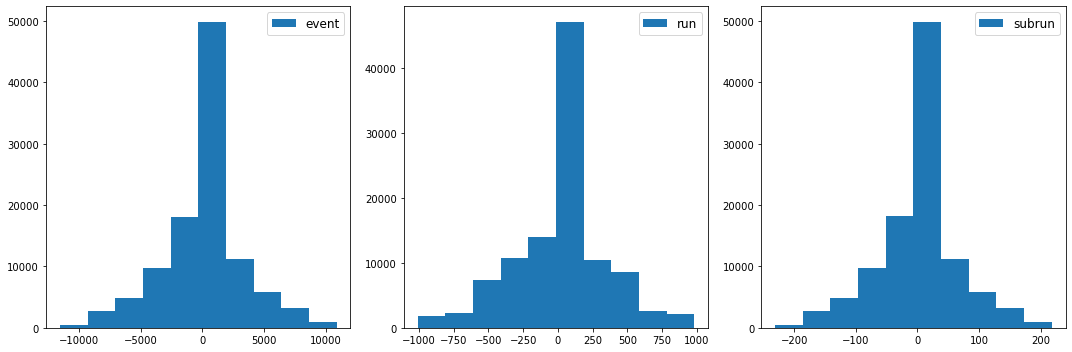

In [23]:
print('File3  %i entries' % len(df_file3))
print('File2  %i entries' % len(df_file2))

def merge_left_only(df_left, df_right):
    df = pd.merge(df_left, df_right, on=['run','subrun','event'],suffixes=('', '_delme'), how='left', indicator=True).query("_merge == 'both'")
    df_new = df[[c for c in df.columns if not c.endswith('_delme')]]
    return df_new

df_file3_new = merge_left_only(df_file3,df_file2)
print('Remaining events for file3: %i' % len(df_file3_new))

df_file2_new = merge_left_only(df_file2,df_file3)
print('Remaining events for file2: %i' % len(df_file2_new))

# ----------------

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2_new.kine_reco_Enu-df_file3_new.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2_new.kine_pio_vtx_dis-df_file3_new.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2_new.kine_pio_energy_1-df_file3_new.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

# -----------------

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2_new.event-df_file3_new.event, label='event')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2_new.run-df_file3_new.run, label='run')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2_new.subrun-df_file3_new.subrun, label='subrun')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

In [25]:
df_file2_new.head()

,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,numu_cc_flag,...,run,subrun,event,runNo,subRunNo,pot_tor875,pot_tor875good,spill_tor875,spill_tor875good,_merge
0,-1.0,-1.0,-1.0,14.896067,73.916512,296.026154,-1.0,-1.0,-1.0,-1.0,...,5233,99,4963,5233.0,99.0,2648.505859,2648.505859,570.0,570.0,both
1,-1.0,-1.0,-1.0,214.317368,-150.303711,49.464687,-1.0,-1.0,-1.0,-1.0,...,5233,99,4980,5470.0,61.0,0.000000,0.000000,0.0,0.0,both
2,-1.0,-1.0,-1.0,239.642227,142.206818,455.549896,-1.0,-1.0,-1.0,-1.0,...,5470,61,3056,5470.0,62.0,0.000000,0.000000,0.0,0.0,both
3,-1.0,-1.0,-1.0,129.459595,148.963364,240.547791,-1.0,-1.0,-1.0,-1.0,...,5470,61,3066,5470.0,63.0,0.000000,0.000000,0.0,0.0,both
4,-1.0,-1.0,-1.0,0.696490,-134.195908,752.185303,-1.0,-1.0,-1.0,-1.0,...,5470,61,3073,5059.0,11.0,2022.065186,2022.065186,423.0,423.0,both


In [27]:
df_file3_new.head()

,kine_reco_Enu,kine_pio_vtx_dis,kine_pio_energy_1,truth_corr_nuvtxX,truth_corr_nuvtxY,truth_corr_nuvtxZ,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,numu_cc_flag,...,run,subrun,event,runNo,subRunNo,pot_tor875,pot_tor875good,spill_tor875,spill_tor875good,_merge
0,-1.0,-1.0,-1.0,14.896067,73.916512,296.026154,-1.0,-1.0,-1.0,-1.0,...,5233,99,4963,5233.0,99.0,4.012238e+15,4.012238e+15,0.0,0.0,both
1,-1.0,-1.0,-1.0,214.317368,-150.303711,49.464687,-1.0,-1.0,-1.0,-1.0,...,5233,99,4980,5066.0,14.0,3.563513e+15,3.563513e+15,0.0,0.0,both
2,-1.0,-1.0,-1.0,-5.454307,119.502953,780.231689,-1.0,-1.0,-1.0,-1.0,...,5066,14,706,5598.0,47.0,7.413017e+15,7.413017e+15,0.0,0.0,both
3,-1.0,-1.0,-1.0,181.752441,-4.253470,835.219055,-1.0,-1.0,-1.0,-1.0,...,5066,14,723,5598.0,48.0,1.617758e+16,1.617758e+16,0.0,0.0,both
4,-1.0,-1.0,-1.0,-21.181168,-2.389918,335.854401,-1.0,-1.0,-1.0,-1.0,...,5066,14,731,5598.0,49.0,1.186537e+16,1.186537e+16,0.0,0.0,both
